In [1]:
import os 
from glob import glob

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
data_paths = glob('../dataset/cifar/train/*.png')
data_paths[0]

'../dataset/cifar/train\\0_frog.png'

In [8]:
path=data_paths[0]
path

'../dataset/cifar/train\\0_frog.png'

In [9]:
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile)

In [10]:
image.shape

TensorShape([32, 32, 3])

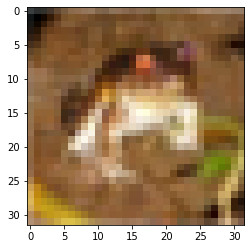

In [11]:
plt.imshow(image)
plt.show()

# tf.data

In [37]:
train_paths = glob('../dataset/cifar/train/*.png')
train_paths[:10]

['../dataset/cifar/train\\0_frog.png',
 '../dataset/cifar/train\\10000_automobile.png',
 '../dataset/cifar/train\\10001_frog.png',
 '../dataset/cifar/train\\10002_frog.png',
 '../dataset/cifar/train\\10003_ship.png',
 '../dataset/cifar/train\\10004_ship.png',
 '../dataset/cifar/train\\10005_cat.png',
 '../dataset/cifar/train\\10006_deer.png',
 '../dataset/cifar/train\\10007_frog.png',
 '../dataset/cifar/train\\10008_airplane.png']

In [38]:
def read_image(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile, dtype=tf.float32)
    return image

In [39]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [40]:
dataset = tf.data.Dataset.from_tensor_slices(train_paths)
dataset = dataset.map(read_image, num_parallel_calls=AUTOTUNE)

In [41]:
tf_image = next(iter(dataset))#for문으로 돌릴때 앞의 하나만 가져옵니다.
tf_image.shape

TensorShape([32, 32, 3])

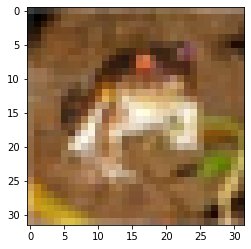

In [42]:
plt.imshow(tf_image)
plt.show()

## Batch로 묶기

In [71]:
batch_size=8

In [72]:
dataset = tf.data.Dataset.from_tensor_slices(train_paths)
dataset = dataset.map(read_image)
dataset = dataset.batch(batch_size)

In [73]:
tf_images = next(iter(dataset))
tf_images.shape

TensorShape([8, 32, 32, 3])

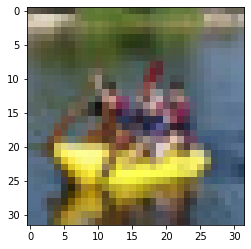

In [75]:
plt.imshow(tf_images[4])
plt.show()

## Shuffle 하기

In [46]:
dataset = tf.data.Dataset.from_tensor_slices(train_paths)
dataset = dataset.map(read_image, num_parallel_calls=AUTOTUNE)
dataset = dataset.batch(4)
dataset = dataset.shuffle(buffer_size=len(train_paths))
#데이터 개수만큼을 버퍼사이즈에 넣어줍니다. 
dataset = dataset.repeat()

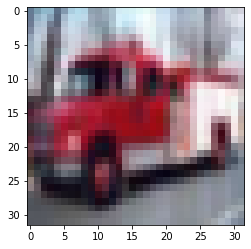

In [47]:
tf_images = next(iter(dataset))
plt.imshow(tf_images[0])
plt.show()

## Label하고 같이 넣기 

In [48]:
path = train_paths[0]
path

'../dataset/cifar/train\\0_frog.png'

In [49]:
os.path.basename(path).replace('.png', '').split('_')[-1]

'frog'

In [50]:
def get_label(path):
    return os.path.basename(path).replace('.png', '').split('_')[-1]

In [51]:
path, get_label(path)

('../dataset/cifar/train\\0_frog.png', 'frog')

In [52]:
train_labels = [get_label(path) for path in train_paths]
train_labels[:5]

['frog', 'automobile', 'frog', 'frog', 'ship']

In [53]:
class_names = np.unique(train_labels)
class_names

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

In [54]:
'frog' == class_names

array([False, False, False, False, False, False,  True, False, False,
       False])

In [55]:
onehot_encoding = np.array('frog' == class_names, np.uint8)
onehot_encoding

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8)

In [56]:
def onehot_encoding(label):
    return np.array(label == class_names, np.uint8)

In [57]:
def load_data(path, label):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile, dtype=tf.float32)
    return image, label

In [58]:
labels = [onehot_encoding(cls_name) for cls_name in train_labels]

In [59]:
dataset = tf.data.Dataset.from_tensor_slices((train_paths, labels))
dataset = dataset.map(load_data, num_parallel_calls=AUTOTUNE)
dataset = dataset.batch(4)
dataset = dataset.shuffle(buffer_size=len(train_paths))
dataset = dataset.repeat()

In [60]:
image, label = next(iter(dataset))

In [61]:
np.array(label[0])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=uint8)

C:\Users\rkdwn\anaconda3\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


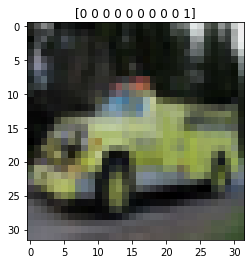

In [62]:
plt.title(np.array(label[0]))
plt.imshow(image[0])
plt.show()

## tensorflow 함수로 label 얻기

In [63]:
path

'../dataset/cifar/train\\0_frog.png'

In [64]:
fname = tf.strings.split(path, '_')[-1]
lbl_name = tf.strings.regex_replace(fname, '.png', '')
lbl_name

<tf.Tensor: shape=(), dtype=string, numpy=b'frog'>

boolean 형태이니 uint8로 바꿔서 원핫인코딩을 해줍니다.

In [65]:
onehot = tf.cast(lbl_name == class_names, tf.uint8)
onehot

<tf.Tensor: shape=(10,), dtype=uint8, numpy=array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8)>

In [66]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return onehot

In [67]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile, dtype=tf.float32)
    label = get_label(path)
    return image, label

In [68]:
dataset = tf.data.Dataset.from_tensor_slices(train_paths)
dataset = dataset.map(load_image_label, num_parallel_calls=AUTOTUNE)
dataset = dataset.batch(4)
dataset = dataset.shuffle(buffer_size=len(train_paths))
dataset = dataset.repeat()

In [69]:
image, label = next(iter(dataset))

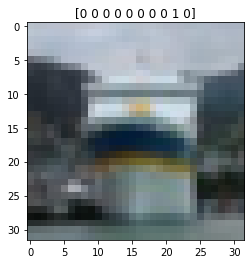

In [70]:
plt.title(np.array(label[0]))
plt.imshow(image[0])
plt.show()